#Tracking# 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    pass
    
# built in python modules
import datetime
import logging
import os
import inspect

# python add-ons
import numpy as np
import pandas as pd

In [2]:
import pvlib
from pvlib.tools import cosd, sind
from pvlib.location import Location

Make some Location objects.

In [3]:
tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
print(tus)
golden = Location(39.742476, -105.1786, 'America/Denver', 1830, 'Golden')
print(golden)
golden_mst = Location(39.742476, -105.1786, 'MST', 1830, 'Golden MST')
print(golden_mst)

Tucson: latitude=32.2, longitude=-111, tz=US/Arizona, altitude=700
Golden: latitude=39.742476, longitude=-105.1786, tz=America/Denver, altitude=1830
Golden MST: latitude=39.742476, longitude=-105.1786, tz=MST, altitude=1830


In [4]:
times = pd.date_range(start=datetime.datetime(2014,3,23), end=datetime.datetime(2014,3,24), freq='5Min')
times_loc = times.tz_localize(tus.pytz)

In [5]:
pyephemout = pvlib.solarposition.pyephem(times, tus)

Here's the full inline version of the tracking algorithm.

In [6]:
SunAz = pyephemout['apparent_azimuth']
SunZen = pyephemout['apparent_zenith']
AxisTilt = 0
AxisAzimuth = 180
Latitude = 32
MaxAngle = 90 
Backtrack = True
GCR = 2.0/7.0
    

times = SunAz.index

Az = SunAz - 180
El = 90 - SunZen
x = cosd(El) * sind(Az)
y = cosd(El) * cosd(Az)
z = sind(El)
    
    
AxisAz = AxisAzimuth - 180;

 
xp = x*cosd(AxisAz) - y*sind(AxisAz);
yp = (x*cosd(AxisTilt)*sind(AxisAz) +
      y*cosd(AxisTilt)*cosd(AxisAz) -
      z*sind(AxisTilt))

zp = (x*sind(AxisTilt)*sind(AxisAz) +
      y*sind(AxisTilt)*cosd(AxisAz) +
      z*cosd(AxisTilt))

# can we use atan2?

# filter to avoid undefined inverse tangent
#tmp(xp~=0) = atand(zp./xp)  # angle from x-y plane to projection of sun vector onto x-z plane
tmp = np.degrees(np.arctan(zp/xp))  # angle from x-y plane to projection of sun vector onto x-z plane
#tmp(xp==0 & zp>=0) = 90     # fill in when atan is undefined
#tmp(xp==0 & zp<0) = -90     # fill in when atan is undefined
#tmp=tmp(:);                  # ensure tmp is a column vector
# Obtain wid by translating tmp to convention for rotation angles.
# Have to account for which quadrant of the x-z plane in which the sun 
# vector lies.  Complete solution here but probably not necessary to 
# consider QIII and QIV.
wid = pd.Series(index=times)
wid[(xp>=0) & (zp>=0)] =  90 - tmp[(xp>=0) & (zp>=0)];  # QI
wid[(xp<0)  & (zp>=0)] = -90 - tmp[(xp<0)  & (zp>=0)];  # QII
wid[(xp<0)  & (zp<0)]  = -90 - tmp[(xp<0)  & (zp<0)];   # QIII
wid[(xp>=0) & (zp<0)]  =  90 - tmp[(xp>=0) & (zp<0)];   # QIV
#wid=wid(:);                  # ensure wid is a column vector

# filter for sun above panel horizon)
#u = zp > 0;

# apply limits to ideal rotation angle
#wid(~u) = 0;  # set horizontal if zenith<0, sun is below panel horizon

# Account for backtracking; modified from [1] to account for rotation
# angle convention being used here.
if Backtrack:
    Lew = 1/GCR
    temp = np.minimum(Lew*cosd(wid), 1)
    wc = np.degrees(np.arccos(temp))   # backtrack angle; always positive (acosd returns values between 0 and 180)
    v = wid < 0
    widc = pd.Series(index=times)
    widc[~v] = wid[~v] - wc[~v] # Eq 4 applied when wid in QI
    widc[v] = wid[v] + wc[v]    # Eq 4 applied when wid in QIV
else:
    widc = wid

#TrkrTheta[u] = widc[u];
#TrkrTheta(~u) = 0;    # set to zero when sun is below panel horizon
#TrkrTheta = TrkrTheta(:);   # ensure column vector format
TrkrTheta = widc.copy()
TrkrTheta[TrkrTheta > MaxAngle] = MaxAngle
TrkrTheta[TrkrTheta < -MaxAngle] = -MaxAngle

Norm = np.array([sind(TrkrTheta), np.zeros_like(TrkrTheta), cosd(TrkrTheta)])

# sun position in vector format in panel-oriented x, y, z coordinates
P = np.array([xp, yp, zp])

# calculate angle-of-incidence on panel
AOI = np.degrees(np.arccos(np.abs(np.sum(P*Norm, axis=0))))

Rot_x = np.array([[1, 0, 0], 
                  [0, cosd(-AxisTilt), -sind(-AxisTilt)], 
                  [0, sind(-AxisTilt), cosd(-AxisTilt)]])
temp = np.dot(Rot_x, Norm) # temp contains the normal vector expressed in earth-surface coordinates (z normal to surface, y aligned with tracker axis parallel to earth)
temp = temp.T  # ensure column format # @wholmgren what?
# projection to plane tangent to earth surface, in earth surface coordinates
projNorm = np.array([temp[:,0], temp[:,1], np.zeros_like(temp[:,2])]) 
tempnorm = np.sqrt(np.nansum(temp**2, axis=1))
projNormnorm = np.sqrt(np.nansum(projNorm**2, axis=1))

#SurfAz = 0.*TrkrTheta;
# calculation of SurfAz
projNorm = projNorm.T
SurfAz = np.degrees(np.arctan(projNorm[:,1]/projNorm[:,0]))

# clean up atan when x-coord is zero
#SurfAz[projNorm(:,1)==0 & projNorm(:,2)>0] =  90;
#SurfAz[projNorm(:,1)==0 & projNorm(:,2)<0] =  -90;
# clean up atan when y-coord is zero
#SurfAz[projNorm(:,2)==0 & projNorm(:,1)>0] =  0;
#SurfAz[projNorm(:,2)==0 & projNorm(:,1)<0] = 180;
# correct for QII and QIII
SurfAz[(projNorm[:,0]<0) & (projNorm[:,1]>0)] += 180 # QII
SurfAz[(projNorm[:,0]<0) & (projNorm[:,1]<0)] += 180 # QIII

# at this point SurfAz contains angles between -90 and +270, where 0 is
# along the positive x-axis, the y-axis is in the direction of the tracker
# azimuth, and positive angles are rotations from the positive x axis towards
# the positive y-axis.
# Adjust to compass angles (clockwise rotation from 0 along the positive y-axis)
SurfAz[SurfAz<=90] = 90 - SurfAz[SurfAz<=90]
SurfAz[SurfAz>90] = 450 - SurfAz[SurfAz>90]

# finally rotate to align y-axis with true north
if Latitude>0:
    SurfAz = SurfAz - AxisAzimuth
else:
    SurfAz = SurfAz - AxisAzimuth - 180
SurfAz[SurfAz<0] = 360 + SurfAz[SurfAz<0]

#divisor = np.round(tempnorm*projNormnorm*10000)/10000
#dividend = np.round(temp*projNorm*10000)/10000


#SurfTilt = 90 - np.degrees(np.arccos(dividend/divisor))

df_out = pd.DataFrame({'AOI':AOI,
                       'SurfAz':SurfAz,
                       'SurfTilt':np.nan},
                      index=times)

df_out[SunZen > 90] = np.nan

In [7]:
SunAz = pyephemout['apparent_azimuth']
SunZen = pyephemout['apparent_zenith']
AxisTilt = 0
AxisAzimuth = 180
Latitude = 32
MaxAngle = 90 
Backtrack = True
GCR = 2.0/7.0

times = SunAz.index

For input ``axis_tilt=0`` and ``axis_azimuth=180``, the calculation axis are y points south, x points west, and z points up.

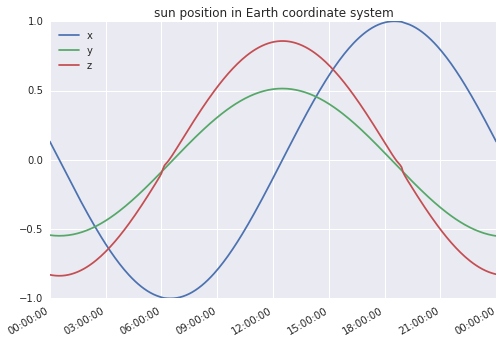

In [8]:
Az = SunAz - 180
El = 90 - SunZen
x = cosd(El) * sind(Az)
y = cosd(El) * cosd(Az)
z = sind(El)

earth_coords = pd.DataFrame({'x':x,'y':y,'z':z})

earth_coords.plot()
plt.title('sun position in Earth coordinate system')

Again, for input ``axis_tilt=0`` and ``axis_azimuth=180``, the calculation axis are y points south, x points west, and z points up.

Transform to panel coordinate system. For North-South oriented trackers parallel to the ground, there is no difference between the Earth system and the panel system. 

Note the difference between ``AxisAzimuth`` and ``AxisAz``.

cos(AxisAz)=1.0, sin(AxisAz)=0.0
cos(AxisTilt)=1.0, sin(AxisTilt)=0.0


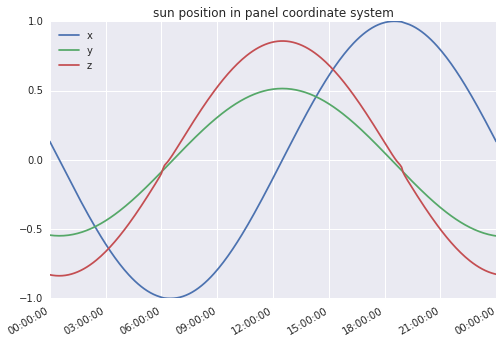

In [9]:
AxisAz = AxisAzimuth - 180;

print('cos(AxisAz)={}, sin(AxisAz)={}'.format(cosd(AxisAz), sind(AxisAz)))
print('cos(AxisTilt)={}, sin(AxisTilt)={}'.format(cosd(AxisTilt), sind(AxisTilt)))

xp = x*cosd(AxisAz) - y*sind(AxisAz);
yp = (x*cosd(AxisTilt)*sind(AxisAz) +
      y*cosd(AxisTilt)*cosd(AxisAz) -
      z*sind(AxisTilt))
zp = (x*sind(AxisTilt)*sind(AxisAz) +
      y*sind(AxisTilt)*cosd(AxisAz) +
      z*cosd(AxisTilt))

panel_coords = pd.DataFrame({'x':xp,'y':yp,'z':zp})

panel_coords.plot()
plt.title('sun position in panel coordinate system')

 The ideal tracking angle ``wid`` is the rotation to place the sun position 
 vector ``(xp, yp, zp)`` in the ``(y, z)`` plane; i.e. normal to the panel and 
 containing the axis of rotation.  ``wid = 0`` indicates that the panel is 
 horizontal.  Here, our convention is that a clockwise rotation is 
 positive, to view rotation angles in the same frame of reference as 
 azimuth.  For example, for a system with tracking axis oriented south, 
 a rotation toward the east is negative, and a rotation to the west is 
 positive.

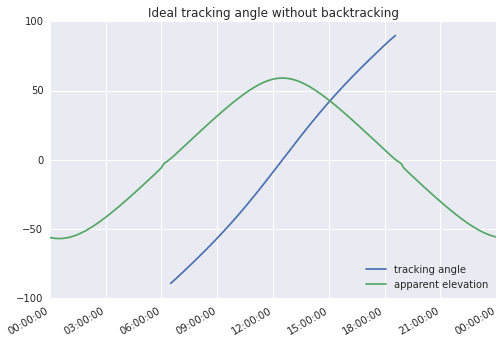

In [10]:
tmp = np.degrees(np.arctan(zp/xp))  # angle from x-y plane to projection of sun vector onto x-z plane

# Obtain wid by translating tmp to convention for rotation angles.
# Have to account for which quadrant of the x-z plane in which the sun 
# vector lies.  Complete solution here but probably not necessary to 
# consider QIII and QIV.
wid = pd.Series(index=times)
wid[(xp>=0) & (zp>=0)] =  90 - tmp[(xp>=0) & (zp>=0)];  # QI
wid[(xp<0)  & (zp>=0)] = -90 - tmp[(xp<0)  & (zp>=0)];  # QII
wid[(xp<0)  & (zp<0)]  = -90 - tmp[(xp<0)  & (zp<0)];   # QIII
wid[(xp>=0) & (zp<0)]  =  90 - tmp[(xp>=0) & (zp<0)];   # QIV

# filter for sun above panel horizon)
u = zp > 0

# apply limits to ideal rotation angle
# set horizontal if zenith<0, sun is below panel horizon
wid[~u] = np.nan

wid.plot(label='tracking angle')
pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend(loc=4)
plt.title('Ideal tracking angle without backtracking')

Account for backtracking; modified from [1] to account for rotation angle convention being used here.

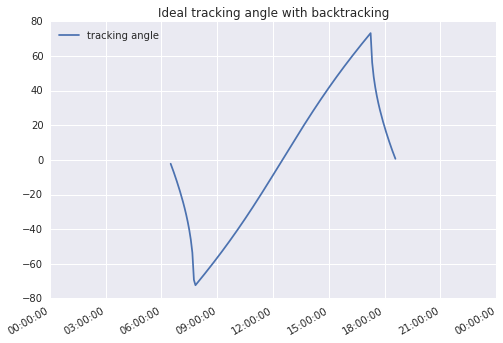

In [11]:
if Backtrack:
    Lew = 1/GCR
    temp = np.minimum(Lew*cosd(wid), 1)

    # backtrack angle
    # (always positive b/c acosd returns values between 0 and 180)
    wc = np.degrees(np.arccos(temp))

    v = wid < 0
    widc = pd.Series(index=times)
    widc[~v] = wid[~v] - wc[~v]; # Eq 4 applied when wid in QI
    widc[v] = wid[v] + wc[v];    # Eq 4 applied when wid in QIV
else:
    widc = wid

widc.plot(label='tracking angle')
#pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend(loc=2)
plt.title('Ideal tracking angle with backtracking')

Compare tracking angle with and without backtracking.

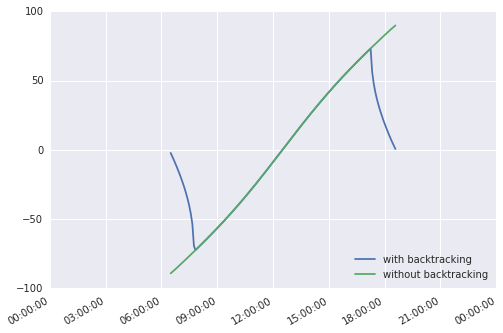

In [12]:
tracking_angles = pd.DataFrame({'with backtracking':widc,'without backtracking':wid})
tracking_angles.plot()
#pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend(loc=4)

Apply angle restriction.

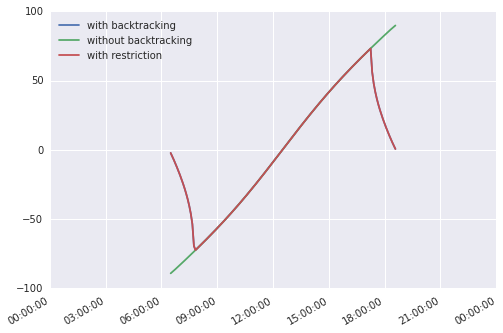

In [13]:
TrkrTheta = widc.copy()
TrkrTheta[TrkrTheta > MaxAngle] = MaxAngle
TrkrTheta[TrkrTheta < -MaxAngle] = -MaxAngle

tracking_angles['with restriction'] = TrkrTheta
tracking_angles.plot()

Calculate panel normal vector in panel x, y, z coordinates.
y-axis is axis of tracker rotation.  TrkrTheta is a compass angle
(clockwise is positive) rather than a trigonometric angle.

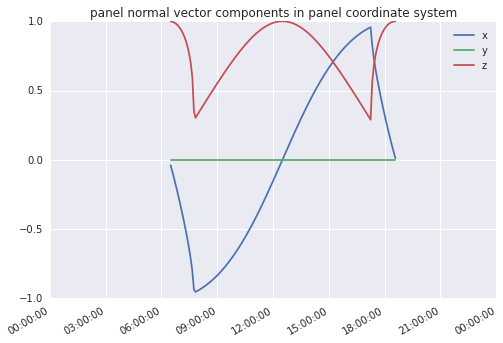

In [14]:
Norm = np.array([sind(TrkrTheta), 
                 TrkrTheta*0,
                 cosd(TrkrTheta)])

norm_df = pd.DataFrame(Norm.T, columns=('x','y','z'), index=times)
norm_df.plot()
plt.title('panel normal vector components in panel coordinate system')
plt.legend()

sun position in vector format in panel-oriented x, y, z coordinates. We've already seen this above, but it's good to look at it again after calculating the tracker normal vector.

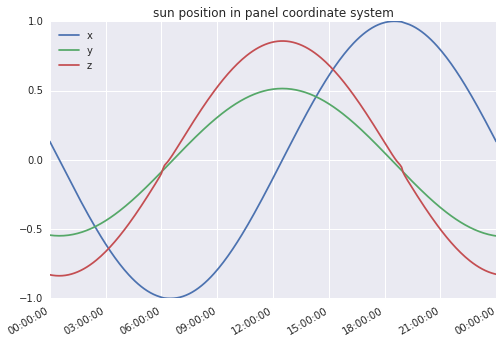

In [15]:
P = np.array([xp, yp, zp])

panel_coords = pd.DataFrame(P.T, columns=('x','y','z'), index=times)

panel_coords.plot()
plt.title('sun position in panel coordinate system')

Calculate angle-of-incidence on panel

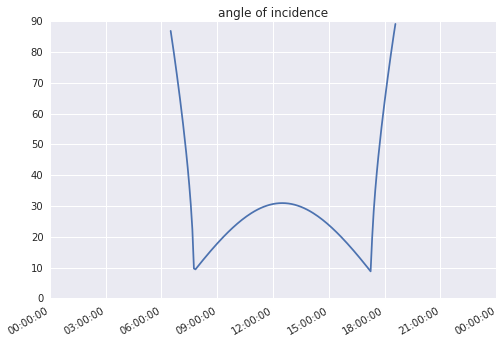

In [16]:
AOI = np.degrees(np.arccos(np.abs(np.sum(P*Norm, axis=0))))
AOI = pd.Series(AOI, index=times)

AOI.plot()
plt.title('angle of incidence')

Calculate panel elevation SurfEl and azimuth SurfAz 
in a coordinate system where the panel elevation is the 
angle from horizontal, and the panel azimuth is
the compass angle (clockwise from north) to the projection 
of the panel's normal to the earth's surface. 
These outputs are provided for convenience and comparison 
with other PV software which use these angle conventions.

Project normal vector to earth surface. First rotate about x-axis by angle -AxisTilt so that y-axis is also parallel to earth surface, then project.

cos(AxisAz)=1.0, sin(AxisAz)=0.0
cos(AxisTilt)=1.0, sin(AxisTilt)=0.0


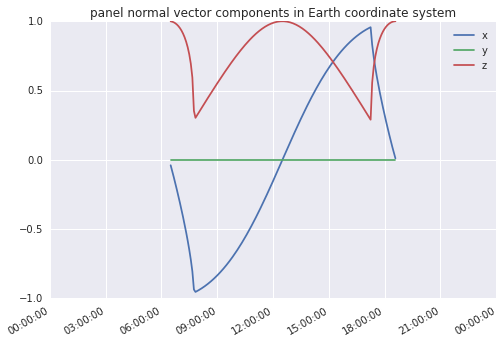

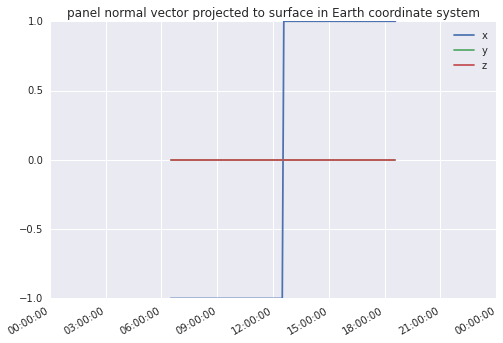

In [17]:
# Calculate standard rotation matrix
print('cos(AxisAz)={}, sin(AxisAz)={}'.format(cosd(AxisAz), sind(AxisAz)))
print('cos(AxisTilt)={}, sin(AxisTilt)={}'.format(cosd(AxisTilt), sind(AxisTilt)))

Rot_x = np.array([[1, 0, 0], 
                  [0, cosd(-AxisTilt), -sind(-AxisTilt)], 
                  [0, sind(-AxisTilt), cosd(-AxisTilt)]])

# temp contains the normal vector expressed in earth-surface coordinates
# (z normal to surface, y aligned with tracker axis parallel to earth)
temp = np.dot(Rot_x, Norm).T

# projection to plane tangent to earth surface,
# in earth surface coordinates
projNorm = np.array([temp[:,0], temp[:,1], temp[:,2]*0]).T

# calculate norms
tempnorm = np.sqrt(np.nansum(temp**2, axis=1))
projNormnorm = np.sqrt(np.nansum(projNorm**2, axis=1))
#print('tempnorm={}, projNormnorm={}'.format(tempnorm, projNormnorm))

projNorm = (projNorm.T / projNormnorm).T

temp_df = pd.DataFrame(temp, columns=('x','y','z'), index=times)
temp_df.plot()
plt.title('panel normal vector components in Earth coordinate system')

projNorm_df = pd.DataFrame(projNorm, columns=('x','y','z'), index=times)
projNorm_df.plot()
plt.title('panel normal vector projected to surface in Earth coordinate system')

Calculate SurfAz

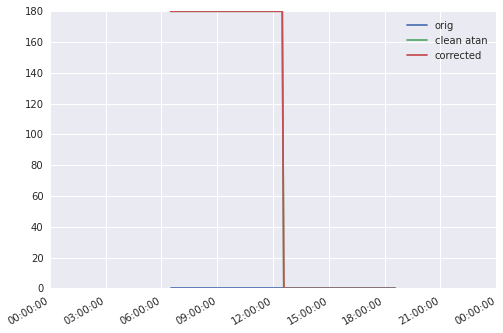

In [18]:
SurfAz = pd.Series(np.degrees(np.arctan(projNorm[:,1]/projNorm[:,0])), index=times)
SurfAz.plot(label='orig')

# clean up atan when x-coord is zero
SurfAz[(projNorm[:,0]==0) & (projNorm[:,1]>0)] =  90
SurfAz[(projNorm[:,0]==0) & (projNorm[:,1]<0)] =  -90
# clean up atan when y-coord is zero
SurfAz[(projNorm[:,1]==0) & (projNorm[:,0]>0)] =  0
SurfAz[(projNorm[:,1]==0) & (projNorm[:,0]<0)] = 180
SurfAz.plot(label='clean atan')
# correct for QII and QIII
SurfAz[(projNorm[:,0]<0) & (projNorm[:,1]>0)] += 180 # QII
SurfAz[(projNorm[:,0]<0) & (projNorm[:,1]<0)] += 180 # QIII

SurfAz.plot(label='corrected')
plt.legend()

At this point SurfAz contains angles between -90 and +270,
where 0 is along the positive x-axis,
the y-axis is in the direction of the tracker azimuth,
and positive angles are rotations from the positive x axis towards
the positive y-axis.
Adjust to compass angles
(clockwise rotation from 0 along the positive y-axis)

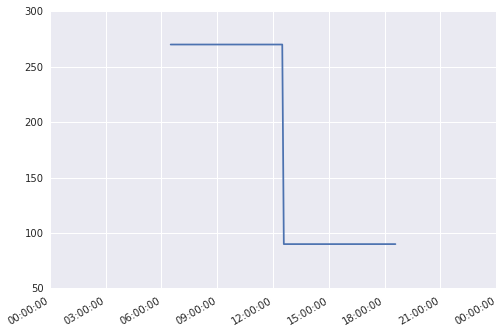

In [19]:
SurfAz[SurfAz<=90] = 90 - SurfAz[SurfAz<=90]
SurfAz[SurfAz>90] = 450 - SurfAz[SurfAz>90]

SurfAz.plot()

Finally rotate to align y-axis with true north

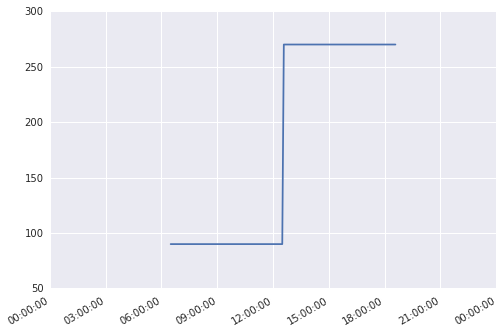

In [20]:
if Latitude > 0:
    SurfAz = SurfAz - AxisAzimuth
else:
    SurfAz = SurfAz - AxisAzimuth - 180
SurfAz[SurfAz<0] = 360 + SurfAz[SurfAz<0]

SurfAz.plot()

According to the MATLAB code, SurfAz is "The azimuth of the rotated panel, determined by projecting the vector normal to the panel's surface to the earth's surface." This is correct, at least for input azimuth = 180.

Calculate SurfTilt

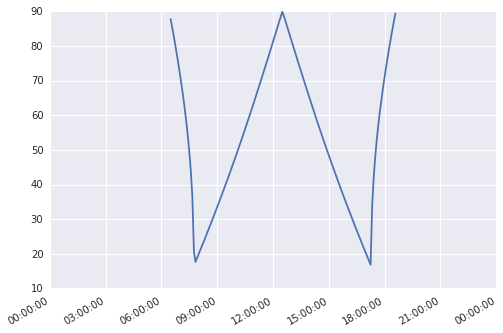

In [21]:
SurfTilt = pd.Series(90 - np.degrees(np.arccos(temp[:,2])), index=times)

SurfTilt.plot()

According to the MATLAB code, SurfTilt is "The angle between the panel surface and the earth surface, accounting for panel rotation." However, the plot above looks like the angle between the normal vector and the earth surface.

In [22]:
reload(pvlib.tracking)

<module 'pvlib.tracking' from '/home/will/git_repos/pvlib-python/pvlib/tracking.pyc'>

With backtracking

In [23]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=180, MaxAngle=90,
                                         Backtrack=True, GCR=2.0/7.0)

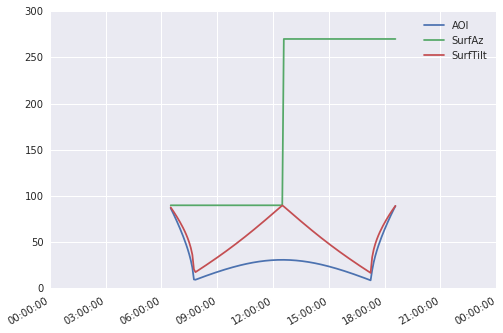

In [24]:
tracker_data.plot()

Without backtracking

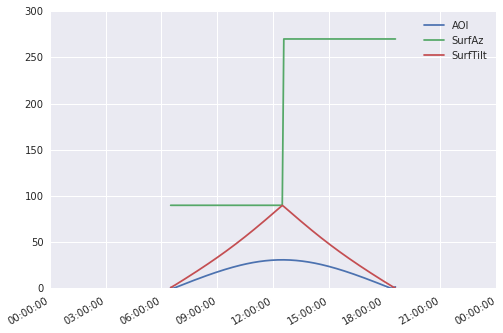

In [25]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=False, GCR=2.0/7.0)
tracker_data.plot()

Explore ground cover ratio

In [26]:
np.linspace(0, 1, 6)

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [27]:
aois = pd.DataFrame(index=pyephemout.index)

tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=False, GCR=2.0/7.0)
aois['no backtrack'] = tracker_data['AOI']

for gcr in np.linspace(0, 1, 6):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=True, GCR=gcr)
    aois[gcr] = tracker_data['AOI']

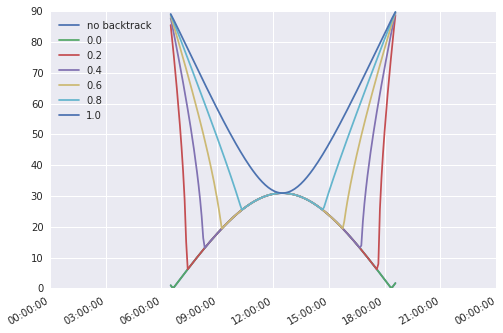

In [28]:
aois.plot()

Ensure that MaxAngle works.

(0, 90)

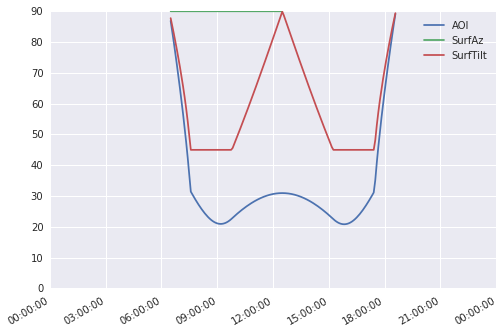

In [29]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=0, MaxAngle=45,
                                         Backtrack=True, GCR=2.0/7.0)
tracker_data.plot()
plt.ylim(0,90)

MaxAngle has the right behavior at least.

Play with AxisTilt.

(0, 90)

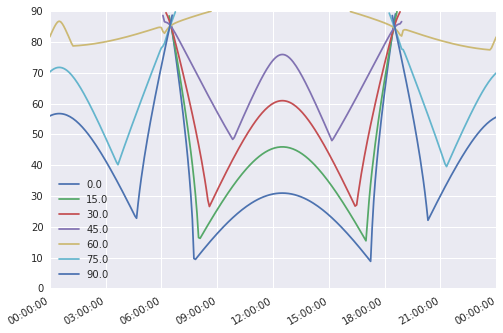

In [30]:
aois = pd.DataFrame(index=pyephemout.index)

for tilt in np.linspace(0, 90, 7):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=tilt, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=True, GCR=2/7.)
    aois[tilt] = tracker_data['AOI']
    
aois.plot()
plt.ylim(0,90)

Makes sense if the panels are facing north at solar noon.

(0, 90)

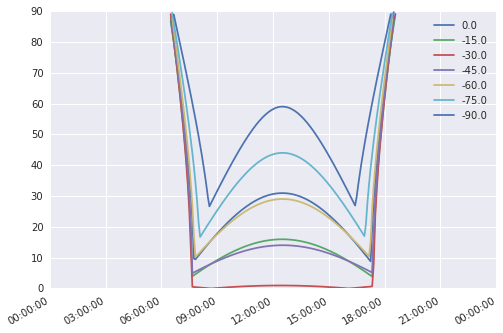

In [31]:
aois = pd.DataFrame(index=pyephemout.index)

for tilt in np.linspace(0, -90, 7):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=tilt, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=True, GCR=2/7.)
    aois[tilt] = tracker_data['AOI']
    
aois.plot()
plt.ylim(0,90)

Makes sense if the panels are facing south at solar noon.

Play with AxisAzimuth

(0, 90)

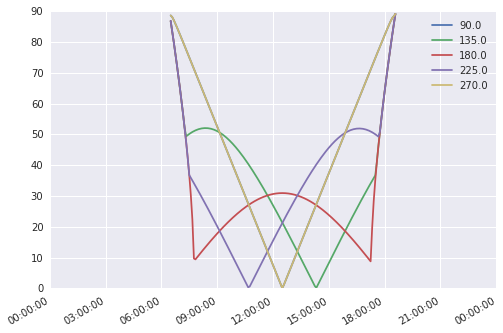

In [32]:
aois = pd.DataFrame(index=pyephemout.index)

for azi in np.linspace(90, 270, 5):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=azi, MaxAngle=90,
                                         Backtrack=True, GCR=2/7.)
    aois[azi] = tracker_data['AOI']
    
aois.plot()
plt.ylim(0,90)

I think that's right...